The purpose of this notebook is to develop architecture and utilities for fit neural network on B → J reconstruction problem.

In [96]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
from IPython.display import display, clear_output

In [98]:
import sys
sys.path.append('../../..')

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import tqdm

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagneticFieldToCurrentInversion2d
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator
from magrec.misc.plot import plot_n_components
from magrec.nn.arch import GeneratorCNN
from magrec import __datapath__

In [100]:
from magrec.misc.load import load_matlab_data

In [101]:
# experimental data where three components of the magnetic field are measured above an Nb wire
# data is from DOI: 10.1103/PhysRevApplied.14.024076
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = torch.tensor(np.array([Bx, By, Bz]), dtype=torch.float32)

dx = 0.408  # in μm
dy = 0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

# this is an axis along which the magnetic field is *usually* measured
# in this case we will project the measured components to simulate such case
theta = 54.7            # degrees
phi = 45.0              # degrees

# Neural net architecture

In [102]:
from magrec.prop.Pipeline import (
    Pipe,
    HannFilter, 
    GaussianFilter,
    Union, 
    PlotResults, 
    FourierZeroDivergenceConstraint2d, 
    CurrentLayerToField, 
    Projection, 
    Sandwich, 
    Padder, 
    Function,
)

from magrec.scripts.prototype_pipeline import Prototype

from magrec.nn.arch import UNet, BnCNN, FCCNN

In [103]:
from magrec.scripts.prototype_pipeline import Prototype

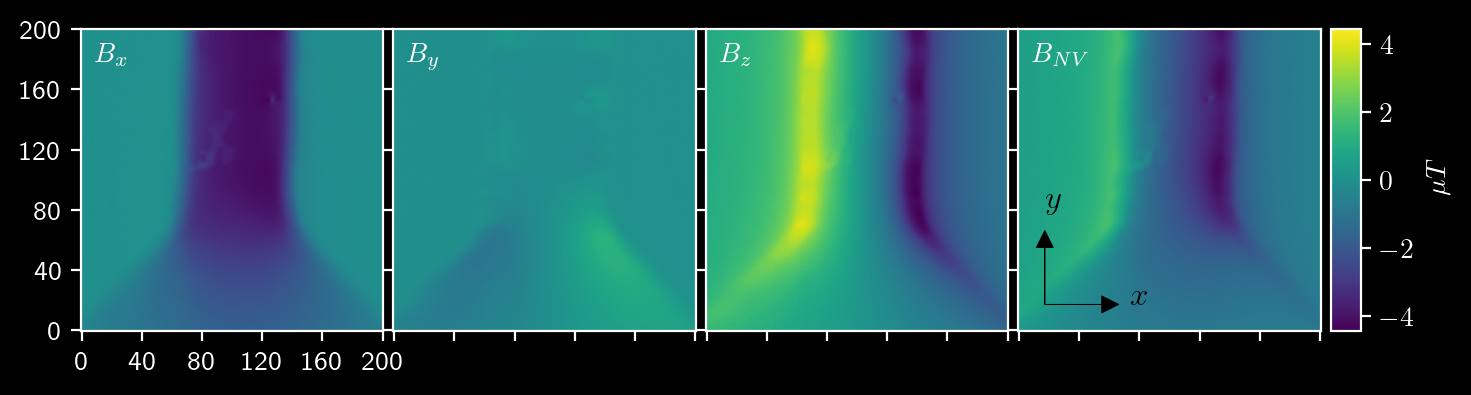

In [104]:
pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[None, [-1], :, :])),
    ('padded_B_NV', Padder(up_to=(16*20, 16*20))),
])

pipe.fit(B).transform(B);

model = Pipe([
    # ('JxJy', Union([('Jx', FourierZeroDivergenceConstraint2d()), ('Jy', 'passthrough')], dim=-3)),
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=BnCNN, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

  epoch    train_loss       dur
-------  ------------  --------
   4019      5.29e-04  4.57e-01
   4200      4.55e-04  3.99e-01
   4400      4.54e-04  2.20e-01
   4600      4.53e-04  2.17e-01
   4800      4.53e-04  3.04e-01
   5000      4.52e-04  2.21e-01
   5200      4.51e-04  2.38e-01
   5400      4.50e-04  1.85e-01
   5600      4.49e-04  3.25e-01
   5800      4.49e-04  1.78e-01
   6000      4.48e-04  2.96e-01


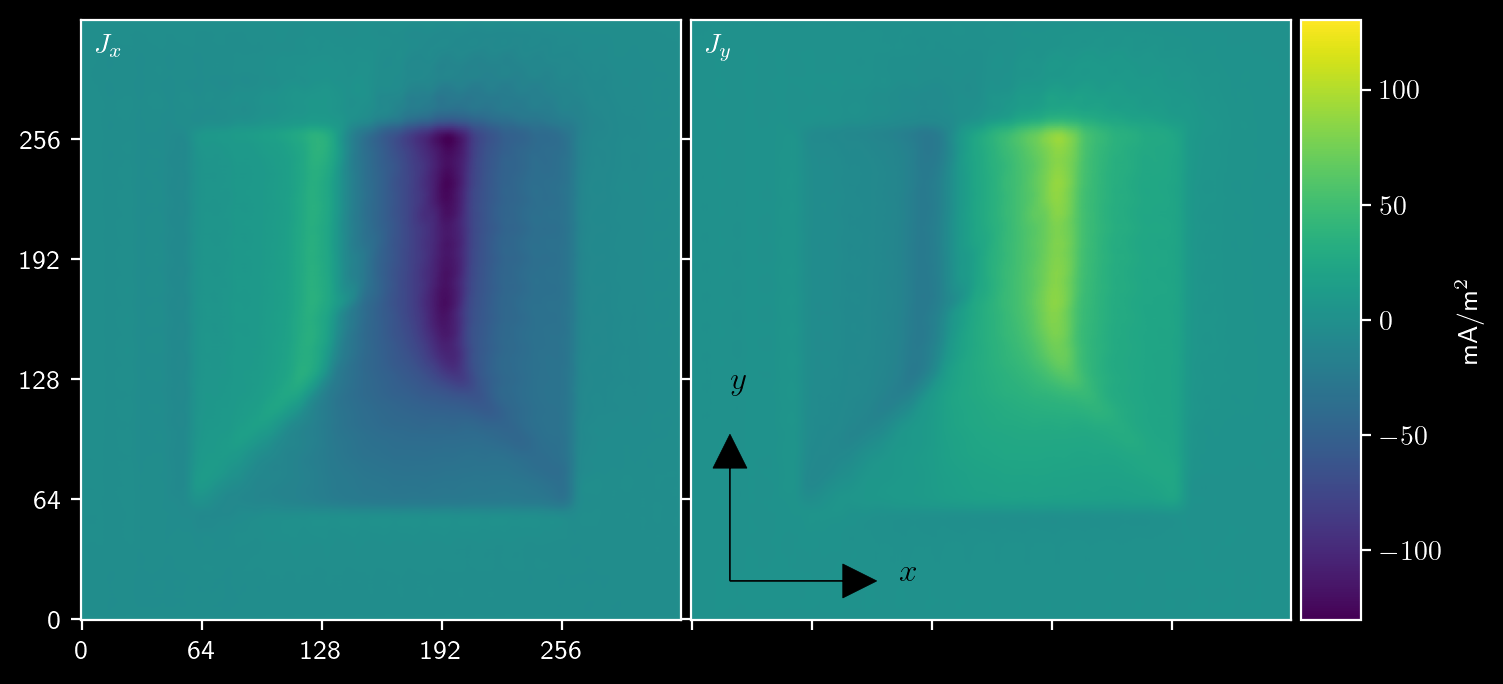

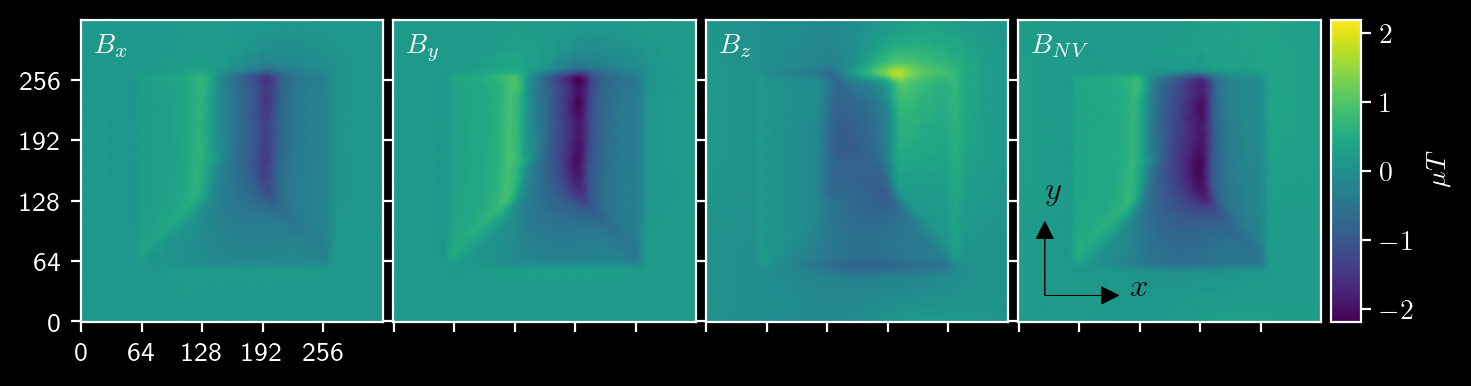

tensor([[[[0.2708, 0.2661, 0.2622,  ..., 0.2831, 0.2829, 0.2790],
          [0.2605, 0.2523, 0.2460,  ..., 0.2724, 0.2735, 0.2711],
          [0.2557, 0.2464, 0.2388,  ..., 0.2701, 0.2712, 0.2679],
          ...,
          [0.2650, 0.2558, 0.2497,  ..., 0.2768, 0.2799, 0.2772],
          [0.2678, 0.2595, 0.2548,  ..., 0.2794, 0.2817, 0.2797],
          [0.2719, 0.2648, 0.2601,  ..., 0.2805, 0.2816, 0.2790]]]],
       grad_fn=<IndexBackward0>)

In [108]:
recon.propagate(B, epochs=2000, print_log_every=200, callbacks__print_log__floatfmt=".2e", lr=0.01)

# Masks

Masks are difficult, because they need to be expanded according to the size of the input. 

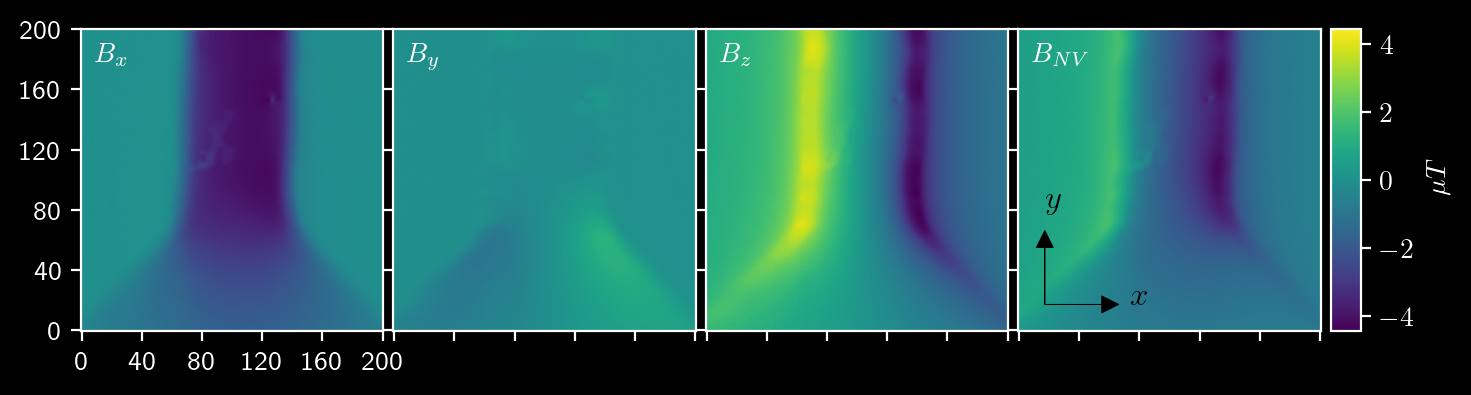

In [94]:
padder = Padder(up_to=(16*20, 16*20))

pipe = Pipe([  
    # NV stands for nitrogen-vacancy (its a quantum defect in diamond crystal used for measuring magnetic field and quantum computing)
    ('B+B_NV', Union([
        ('B', 'passthrough'),
        ('B_NV', Projection(theta=theta, phi=phi)),
    ], dim=-3)),
    ('plot1', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[None, [-1], :, :])),
    ('padded_B_NV', padder),
])

pipe.fit(B).transform(B);

padding = padder.padding
threshold = -0.2
mask = torch.where(B[0] < threshold, torch.ones_like(B[0]), torch.zeros_like(B[0]))
mask = torch.nn.functional.pad(mask, (0, 0, padding[-3], padding[-4]), mode='constant', value=0.0)
mask = torch.nn.functional.pad(mask, (padding[-1], padding[-2], 0, 0), mode='constant', value=1.0)
def apply_mask(x):
    masked_x = mask * x
    return masked_x

mask_fn = Function(apply_mask)

model = Pipe([
    ('plot1', PlotResults(labels=[r"$J_x$", r"$J_y$"], units=r"mA/m$^2$")),
    ('mask', mask_fn),
    ('B', CurrentLayerToField(dx=dx, dy=dy, height=height, layer_thickness=layer_thickness)),
    ('B+B_NV', Union([('B', 'passthrough'), ('B_NV', Projection(theta=theta, phi=phi))], dim=-3)),
    ('plot2', PlotResults(labels=[r"$B_x$", r"$B_y$", r"$B_z$", r"$B_{NV}$"], units=r"$\mu T$")),
    ('B_NV', Function(lambda x: x[..., [-1], :, :])),
])

recon = Prototype(
    net=UNet, 
    model=model, 
    pipe=pipe, 
    max_epochs=20, 
    n_channels_in=1, 
    n_channels_out=2
    )

  epoch    train_loss       dur
-------  ------------  --------
    421      2.99e-02  3.21e-01
    440      4.43e-02  2.86e-01
    460      3.57e-02  8.42e-01
    480      3.52e-02  4.33e-01
    500      3.50e-02  2.66e-01
    520      3.66e-02  6.38e-01
    540      3.53e-02  5.00e-01


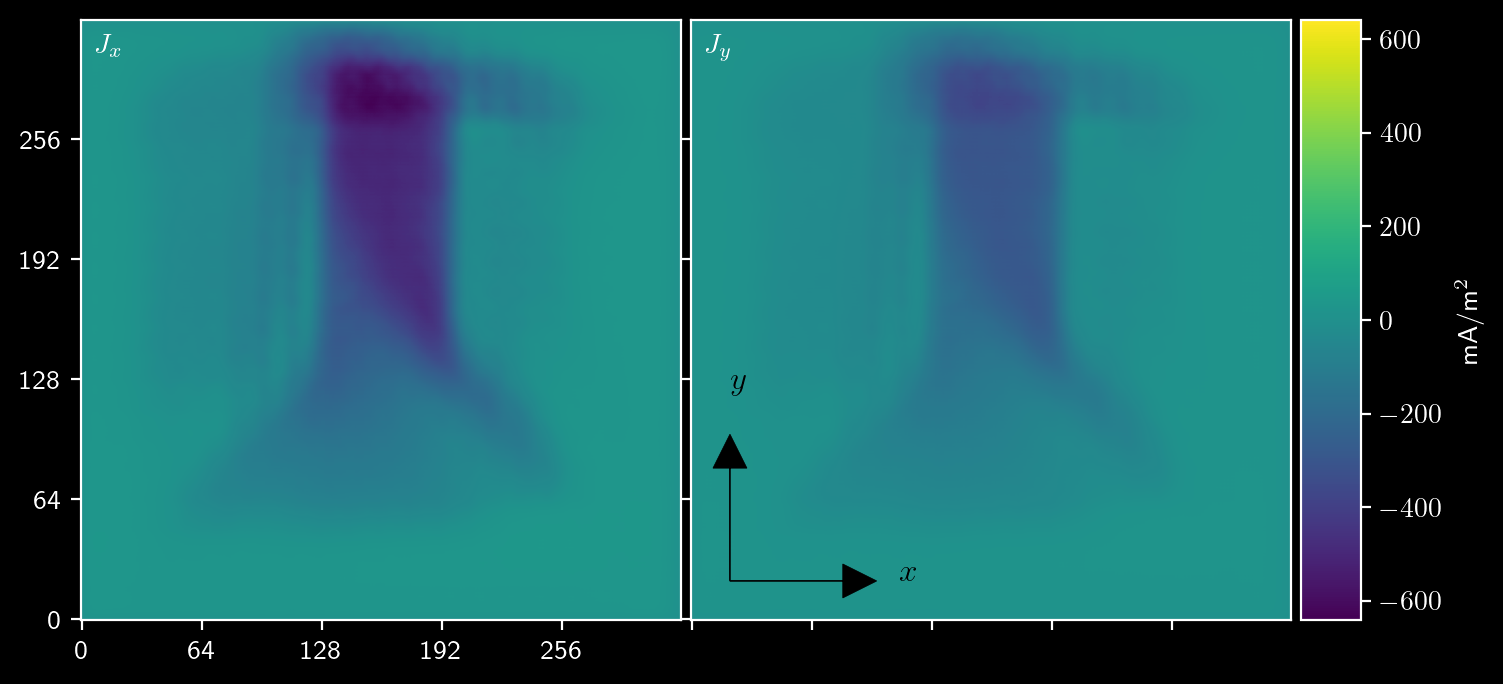

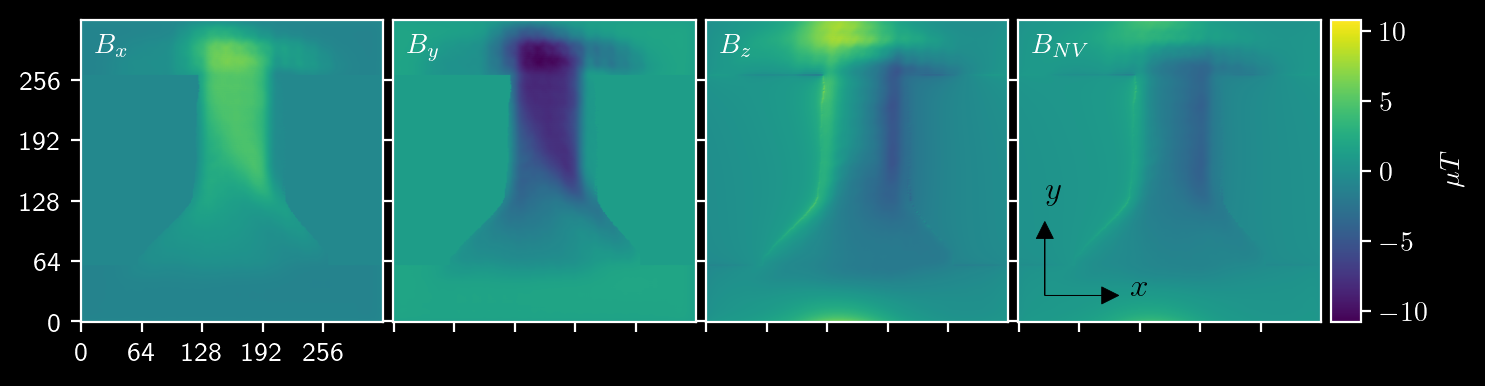

tensor([[[[0.4899, 0.4952, 0.4943,  ..., 0.4009, 0.4208, 0.4575],
          [0.5160, 0.5245, 0.5270,  ..., 0.3991, 0.4180, 0.4656],
          [0.5463, 0.5598, 0.5645,  ..., 0.3985, 0.4176, 0.4776],
          ...,
          [0.5242, 0.5405, 0.5550,  ..., 0.4373, 0.4474, 0.4810],
          [0.5055, 0.5197, 0.5311,  ..., 0.4308, 0.4422, 0.4702],
          [0.4815, 0.4886, 0.4906,  ..., 0.4146, 0.4317, 0.4583]]]],
       grad_fn=<IndexBackward0>)

In [99]:
recon.propagate(B, epochs=200, print_log_every=20, callbacks__print_log__floatfmt=".2e", lr=0.1)

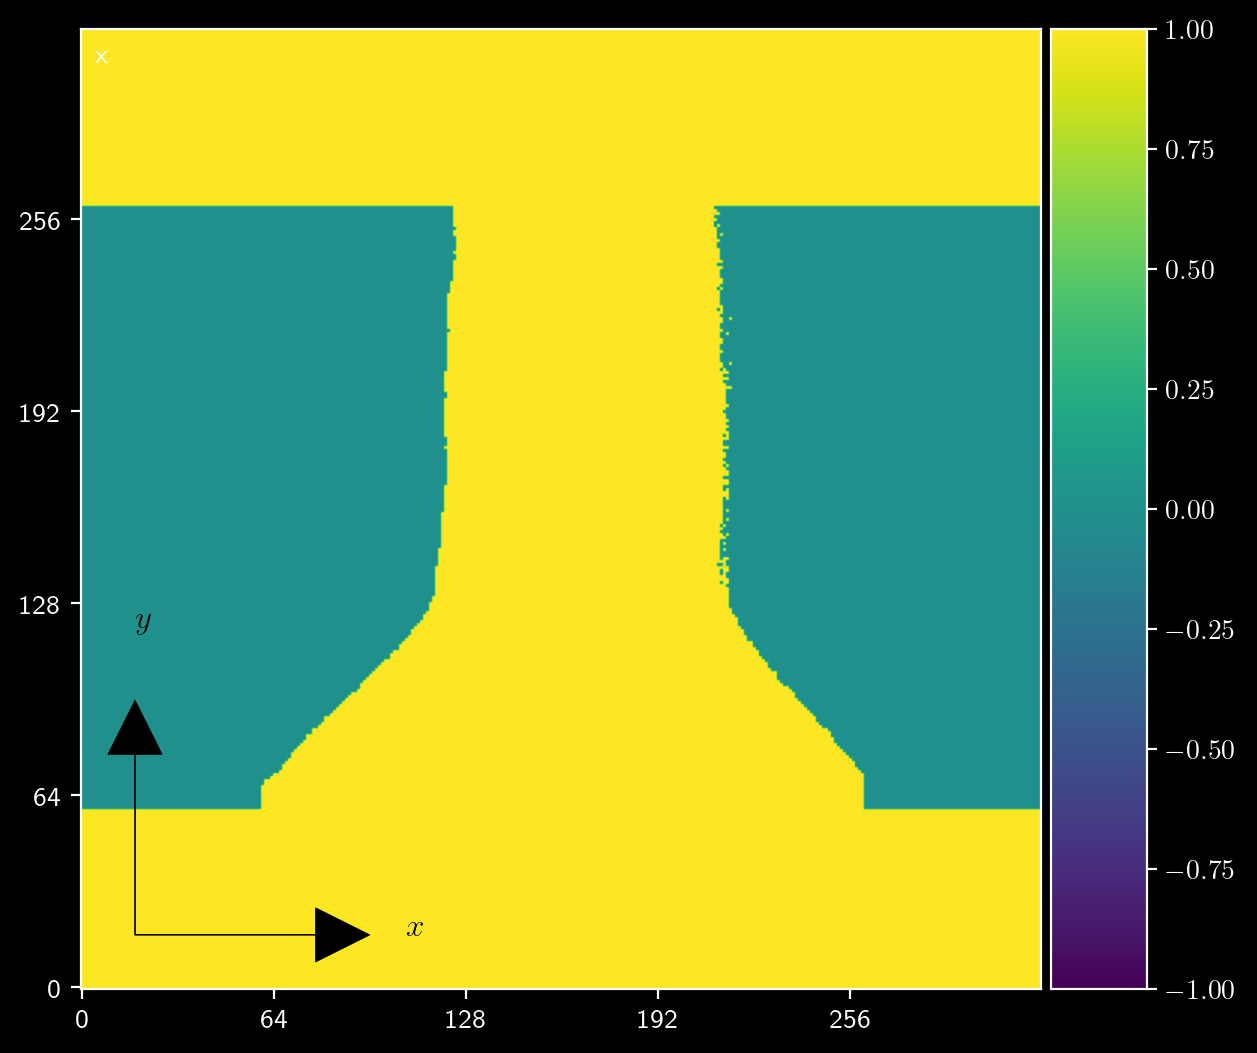

In [100]:
plot_n_components(mask)

# Proper PINN

Here we try to define a PINN that encodes the physics of the problem and models the $J$ as a function of grid points $x$ and $y$, that is, the neural network function $u_{NN}$ encodes $J(x, y) = u_{NN}(x, y)$ and it uses the PDEs known for the problem to constrain the solution.

In [93]:
xN, yN = B.shape[-2:]
xD, yD = 50, 50
xs = torch.linspace(0, xN + 2 * xD, xN + 2 * xD, requires_grad=True)
ys = torch.linspace(0, yN + 2 * yD, yN + 2 * yD, requires_grad=True)
mesh = torch.stack(torch.meshgrid(xs, ys, indexing="xy"), dim=0)
n_channels_in = 2
n_channels_out = 2

net = FCCNN(n_channels_in=n_channels_in, n_channels_out=n_channels_out)

J = net(mesh)
mse_loss = torch.nn.MSELoss()


def div(J):
    # J is a tensor of shape (2, H, W)
    # mesh is a tensor of shape (2, H, W)
    # we want to compute the divergence of J at each point in mesh
    # to do this we take the partial derivatives of J with respect to x and y
    # and then sum them together
    dJ, = torch.autograd.grad(
        J, mesh, grad_outputs=torch.ones_like(J), retain_graph=False, create_graph=True
    )
    return dJ[0, :, :] + dJ[1, :, :]


# define a region of interest
# x0, x1, y0, y1 are the bounds of the measurement region
ROI = (
    (mesh[0, :, :] >= xD)
    & (mesh[0, :, :] <= xN + xD)
    & (mesh[1, :, :] >= yD)
    & (mesh[1, :, :] <= yN + yD)
)

model = CurrentPropagator2d(
    source_shape=(xN + 2 * xD, yN + 2 * yD),
    dx=dx,
    dy=dy,
    height=height,
    layer_thickness=layer_thickness,
    real_signal=False,
)


def loss_fn(J, a=1.0):
    term1 = mse_loss(div(J), torch.zeros_like(div(J)))
    term2 = mse_loss(model(J)[:, ROI].reshape(-1, xN, yN), B)
    return term1 + a * term2


optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

for _ in tqdm.tqdm(range(1000), desc="Training"):
    J = net(mesh)
    loss = loss_fn(J)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

Training:   0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [94]:
J.grad

/opt/homebrew/Caskroom/miniconda/base/envs/currec/lib/python3.10/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1660136240338/work/build/aten/src/ATen/core/TensorBody.h:482.)
  return self._grad
